In [1]:
# G-NLL Baseline Analysis Notebook
# This notebook analyzes the G-NLL (Greedy Negative Log-Likelihood) baseline results
# Includes: AUROC analysis, ROC curves, sample answers, ROUGE scores, and LLM judge metrics

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import os
import glob
from pathlib import Path
import json

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Configuration

Set the paths to your validation_generations.pkl files. You can either:
1. Use the latest run automatically
2. Specify a specific run directory
3. Provide a direct path to the pickle file


In [2]:
# Configuration: Set paths to your pickle files
# Option 1: Use the latest run automatically
wandb_dir = "../boldis/uncertainty/wandb"

# For short answers
short_run_dirs = glob.glob(os.path.join(wandb_dir, "run-*"))
if short_run_dirs:
    latest_short_run = max(short_run_dirs, key=os.path.getmtime)
    short_run_name = os.path.basename(latest_short_run)
    print(f"Using latest run for short answers: {short_run_name}")
else:
    short_run_name = None
    print("No wandb runs found for short answers")

# For long answers (you may need to specify manually)
long_run_name = None  # Set this manually if different from short

# Option 2: Specify specific runs (uncomment and modify)
short_run_name = "run-20251107_121616-5dlvyae5"  # Example
long_run_name = "run-20251107_162702-uir95r78"     # Example

# Option 3: Direct paths (uncomment and set)
# short_pickle_path = "path/to/short/validation_generations.pkl"
# long_pickle_path = "path/to/long/validation_generations.pkl"

# Construct paths
if short_run_name:
    short_pickle_path = os.path.join(wandb_dir, short_run_name, "files", "validation_generations.pkl")
    if not os.path.exists(short_pickle_path):
        print(f"⚠️ Warning: {short_pickle_path} not found")
        short_pickle_path = None
    else:
        print(f"✅ Short answers pickle: {short_pickle_path}")
else:
    short_pickle_path = None

if long_run_name:
    long_pickle_path = os.path.join(wandb_dir, long_run_name, "files", "validation_generations.pkl")
    if not os.path.exists(long_pickle_path):
        print(f"⚠️ Warning: {long_pickle_path} not found")
        long_pickle_path = None
    else:
        print(f"✅ Long answers pickle: {long_pickle_path}")
else:
    long_pickle_path = None

# ROUGE threshold for correctness (for short answers)
ROUGE_THRESHOLD = 0.3


Using latest run for short answers: run-20251107_162702-uir95r78
✅ Short answers pickle: ../boldis/uncertainty/wandb/run-20251107_121616-5dlvyae5/files/validation_generations.pkl
✅ Long answers pickle: ../boldis/uncertainty/wandb/run-20251107_162702-uir95r78/files/validation_generations.pkl


## Core Functions

All functions from `run_gnll_baseline.py` for computing AUROC and analyzing results.


In [3]:
def compute_gnll_auroc(pickle_path, use_rouge=False, rouge_threshold=0.3, return_details=False):
    """
    Compute AUROC for G-NLL baseline.
    
    Args:
        pickle_path: Path to validation_generations.pkl
        use_rouge: If True, use ROUGE scores for correctness (for short answers)
                   If False, use LLM judge accuracy (for long answers)
        rouge_threshold: ROUGE-L threshold for correctness (if use_rouge=True)
        return_details: If True, return detailed data including all examples
    
    Returns:
        Dictionary with results, and optionally detailed data
    """
    print(f"\n{'='*80}")
    print(f"Computing G-NLL AUROC...")
    print(f"{'='*80}")
    print(f"Loading generations from: {pickle_path}")
    
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Loaded {len(data)} examples")
    
    y_true = []
    gnll_uncertainties = []
    example_ids = []
    responses = []
    rouge_scores = []
    judge_accuracies = []
    questions = []
    references = []
    
    if use_rouge:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        print(f"Using ROUGE-L threshold: {rouge_threshold}")
    else:
        print("Using LLM judge accuracy (from 'accuracy' field)")
    
    for example_id, entry in data.items():
        if 'most_likely_answer' not in entry:
            continue
            
        mla = entry['most_likely_answer']
        pred_answer = mla.get('response', '').strip()
        
        if use_rouge:
            # Use ROUGE score for correctness
            if 'reference' in entry and 'answers' in entry['reference']:
                true_answers = entry['reference']['answers']['text']
                best_rougeL = 0.0
                best_rouge1 = 0.0
                best_rouge2 = 0.0
                for ref in true_answers:
                    score = scorer.score(ref.strip(), pred_answer)
                    best_rougeL = max(best_rougeL, score['rougeL'].fmeasure)
                    best_rouge1 = max(best_rouge1, score['rouge1'].fmeasure)
                    best_rouge2 = max(best_rouge2, score['rouge2'].fmeasure)
                is_correct = int(best_rougeL >= rouge_threshold)
                rouge_scores.append({
                    'rouge1': best_rouge1,
                    'rouge2': best_rouge2,
                    'rougeL': best_rougeL
                })
            else:
                continue
        else:
            # Use LLM judge accuracy
            judge_acc = mla.get('accuracy', 0.0)
            is_correct = int(judge_acc > 0.5)
            judge_accuracies.append(judge_acc)
            rouge_scores.append(None)
        
        # Compute G-NLL (sum of token log-probs, negated)
        if 'token_log_likelihoods' in mla:
            token_log_likelihoods = mla['token_log_likelihoods']
            sequence_nll = -sum(token_log_likelihoods)  # Negative log likelihood
            gnll_uncertainties.append(sequence_nll)
            y_true.append(is_correct)
            example_ids.append(example_id)
            responses.append(pred_answer)
            questions.append(entry.get('question', ''))
            if 'reference' in entry and 'answers' in entry['reference']:
                references.append(entry['reference']['answers']['text'])
            else:
                references.append([])
        else:
            print(f"Warning: No token_log_likelihoods for example {example_id}")
    
    if len(y_true) == 0:
        print("❌ No valid examples found!")
        return None
    
    # Compute AUROC
    try:
        # For AUROC, higher uncertainty (higher NLL) should predict incorrect answers
        # roc_auc_score expects higher scores to predict positive class (correct=1)
        # So we negate G-NLL: higher confidence (lower NLL) should predict correct answers
        auroc = roc_auc_score(y_true, -np.array(gnll_uncertainties))
        
        # Also compute ROC curve for visualization
        fpr, tpr, thresholds = roc_curve(y_true, -np.array(gnll_uncertainties))
        
        accuracy = sum(y_true) / len(y_true) if len(y_true) > 0 else 0
        
        results = {
            'G-NLL_AUROC': auroc,
            'Accuracy': accuracy,
            'Num_examples': len(y_true),
            'Num_correct': int(sum(y_true)),
            'Num_incorrect': int(len(y_true) - sum(y_true)),
            'Mean_G-NLL': np.mean(gnll_uncertainties),
            'Std_G-NLL': np.std(gnll_uncertainties),
            'Min_G-NLL': np.min(gnll_uncertainties),
            'Max_G-NLL': np.max(gnll_uncertainties),
            'ROC_curve': {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds
            }
        }
        
        print(f"\nResults:")
        print(f"  G-NLL AUROC: {auroc:.4f}")
        print(f"  Accuracy: {accuracy:.4f} ({int(sum(y_true))}/{len(y_true)})")
        print(f"  Number of examples: {len(y_true)}")
        print(f"  Mean G-NLL: {np.mean(gnll_uncertainties):.4f}")
        print(f"  Std G-NLL: {np.std(gnll_uncertainties):.4f}")
        print(f"  Min G-NLL: {np.min(gnll_uncertainties):.4f}")
        print(f"  Max G-NLL: {np.max(gnll_uncertainties):.4f}")
        
        if return_details:
            details = {
                'example_ids': example_ids,
                'y_true': y_true,
                'gnll_uncertainties': gnll_uncertainties,
                'responses': responses,
                'questions': questions,
                'references': references,
                'rouge_scores': rouge_scores,
                'judge_accuracies': judge_accuracies if not use_rouge else None
            }
            return results, details
        else:
            return results
        
    except ValueError as e:
        print(f"❌ Error computing AUROC: {e}")
        print(f"This might happen if all labels are the same (all correct or all incorrect)")
        return None


In [4]:
# Analyze short answers (if available)
short_results_rouge = None
short_results_judge = None
short_details_rouge = None
short_details_judge = None

if short_pickle_path and os.path.exists(short_pickle_path):
    print("="*80)
    print("ANALYZING SHORT ANSWERS")
    print("="*80)
    
    # With ROUGE
    print("\n--- Short Answers: ROUGE-based correctness ---")
    result = compute_gnll_auroc(short_pickle_path, use_rouge=True, rouge_threshold=ROUGE_THRESHOLD, return_details=True)
    if result:
        short_results_rouge, short_details_rouge = result
    
    # With LLM Judge
    print("\n--- Short Answers: LLM Judge-based correctness ---")
    result = compute_gnll_auroc(short_pickle_path, use_rouge=False, return_details=True)
    if result:
        short_results_judge, short_details_judge = result
else:
    print("⚠️ Short answers pickle file not found. Set short_pickle_path manually.")


ANALYZING SHORT ANSWERS

--- Short Answers: ROUGE-based correctness ---

Computing G-NLL AUROC...
Loading generations from: ../boldis/uncertainty/wandb/run-20251107_121616-5dlvyae5/files/validation_generations.pkl
Loaded 400 examples
Using ROUGE-L threshold: 0.3

Results:
  G-NLL AUROC: 0.7579
  Accuracy: 0.7550 (302/400)
  Number of examples: 400
  Mean G-NLL: 0.8047
  Std G-NLL: 1.4629
  Min G-NLL: 0.0001
  Max G-NLL: 9.8240

--- Short Answers: LLM Judge-based correctness ---

Computing G-NLL AUROC...
Loading generations from: ../boldis/uncertainty/wandb/run-20251107_121616-5dlvyae5/files/validation_generations.pkl
Loaded 400 examples
Using LLM judge accuracy (from 'accuracy' field)

Results:
  G-NLL AUROC: 0.7575
  Accuracy: 0.7275 (291/400)
  Number of examples: 400
  Mean G-NLL: 0.8047
  Std G-NLL: 1.4629
  Min G-NLL: 0.0001
  Max G-NLL: 9.8240


In [5]:
# Analyze long answers (if available)
long_results_judge = None
long_details_judge = None

if long_pickle_path and os.path.exists(long_pickle_path):
    print("="*80)
    print("ANALYZING LONG ANSWERS")
    print("="*80)
    
    print("\n--- Long Answers: LLM Judge-based correctness ---")
    result = compute_gnll_auroc(long_pickle_path, use_rouge=False, return_details=True)
    if result:
        long_results_judge, long_details_judge = result
else:
    print("⚠️ Long answers pickle file not found. Set long_pickle_path manually.")


ANALYZING LONG ANSWERS

--- Long Answers: LLM Judge-based correctness ---

Computing G-NLL AUROC...
Loading generations from: ../boldis/uncertainty/wandb/run-20251107_162702-uir95r78/files/validation_generations.pkl
Loaded 400 examples
Using LLM judge accuracy (from 'accuracy' field)

Results:
  G-NLL AUROC: 0.7516
  Accuracy: 0.7300 (292/400)
  Number of examples: 400
  Mean G-NLL: 0.9776
  Std G-NLL: 1.7197
  Min G-NLL: 0.0001
  Max G-NLL: 13.4798


## Visualizations

### 1. ROC Curves


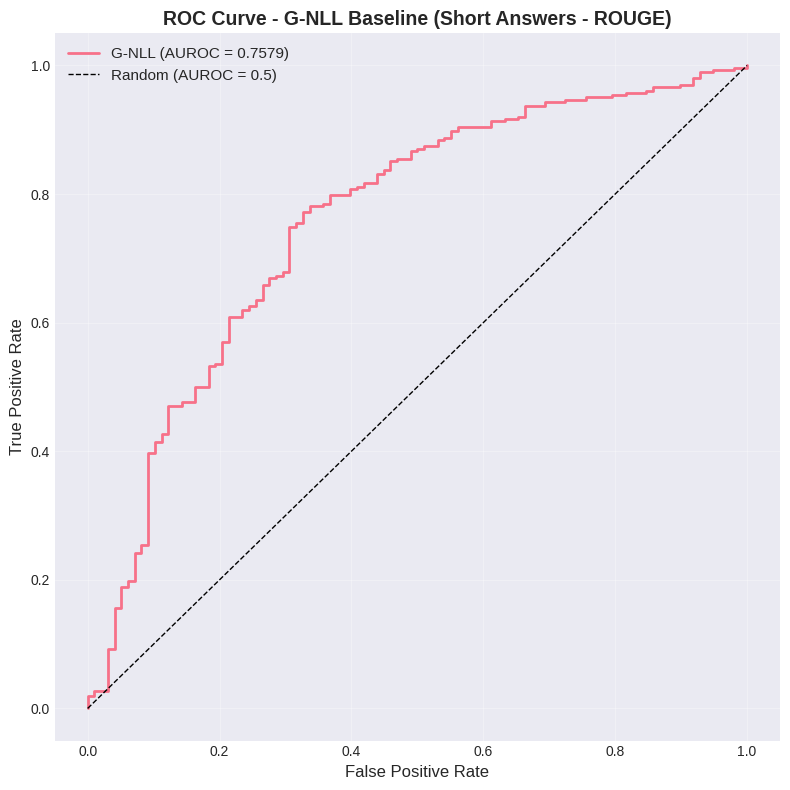

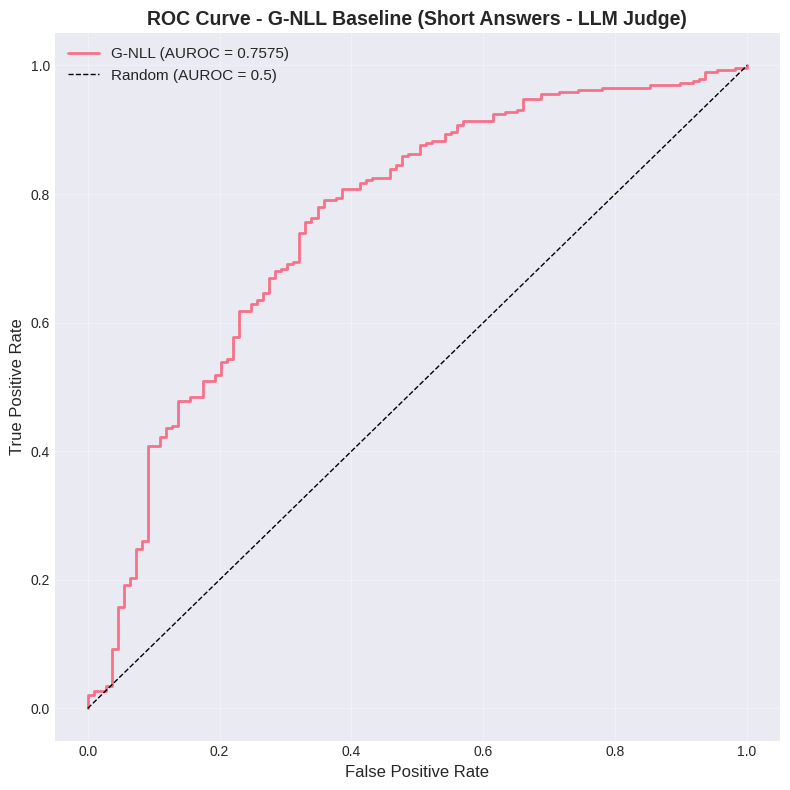

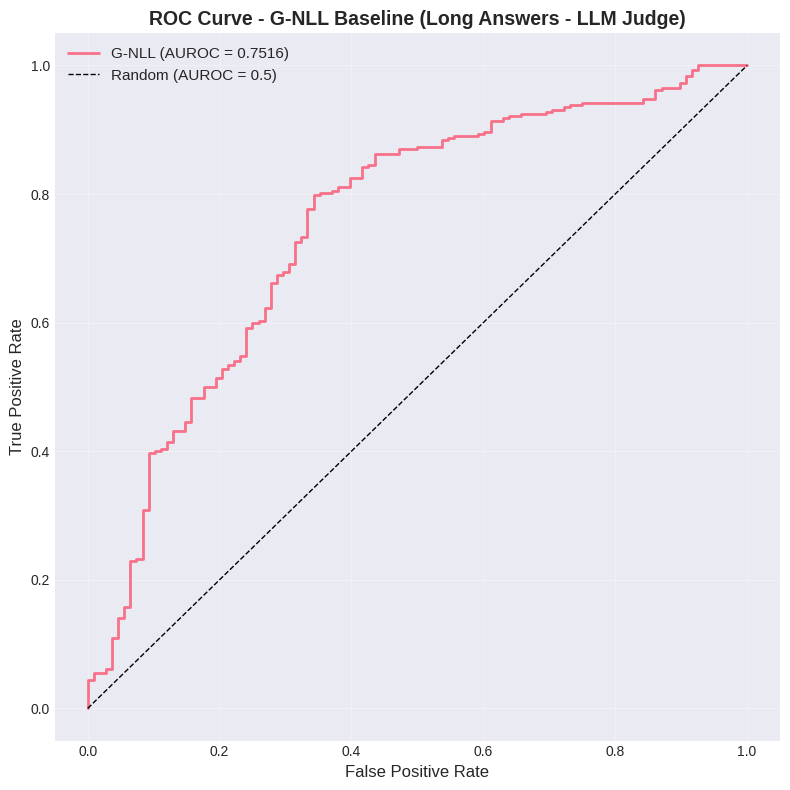

In [6]:
def plot_roc_curve(results_dict, title_suffix=""):
    """Plot ROC curve from results dictionary."""
    if not results_dict or 'ROC_curve' not in results_dict:
        print("No ROC curve data available")
        return
    
    fpr = results_dict['ROC_curve']['fpr']
    tpr = results_dict['ROC_curve']['tpr']
    auroc = results_dict['G-NLL_AUROC']
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'G-NLL (AUROC = {auroc:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUROC = 0.5)', linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - G-NLL Baseline{title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ROC curves
if short_results_rouge:
    plot_roc_curve(short_results_rouge, " (Short Answers - ROUGE)")

if short_results_judge:
    plot_roc_curve(short_results_judge, " (Short Answers - LLM Judge)")

if long_results_judge:
    plot_roc_curve(long_results_judge, " (Long Answers - LLM Judge)")


### 2. G-NLL Distribution: Correct vs Incorrect


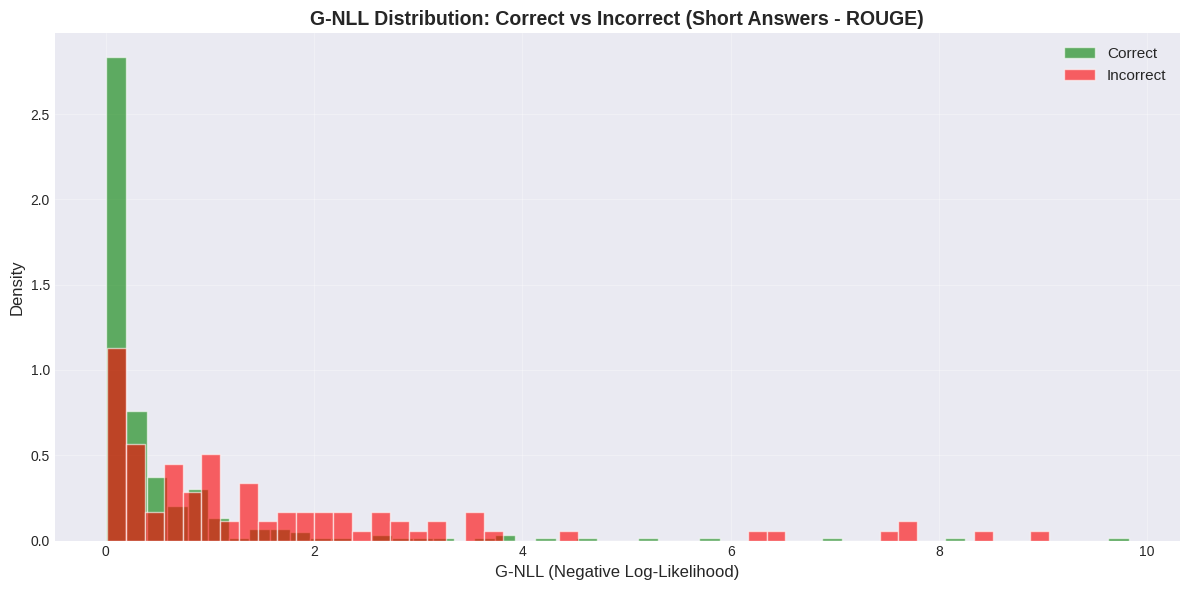


Statistics (Short Answers - ROUGE):
  Correct answers - Mean G-NLL: 0.5363, Std: 1.1375
  Incorrect answers - Mean G-NLL: 1.6321, Std: 1.9598


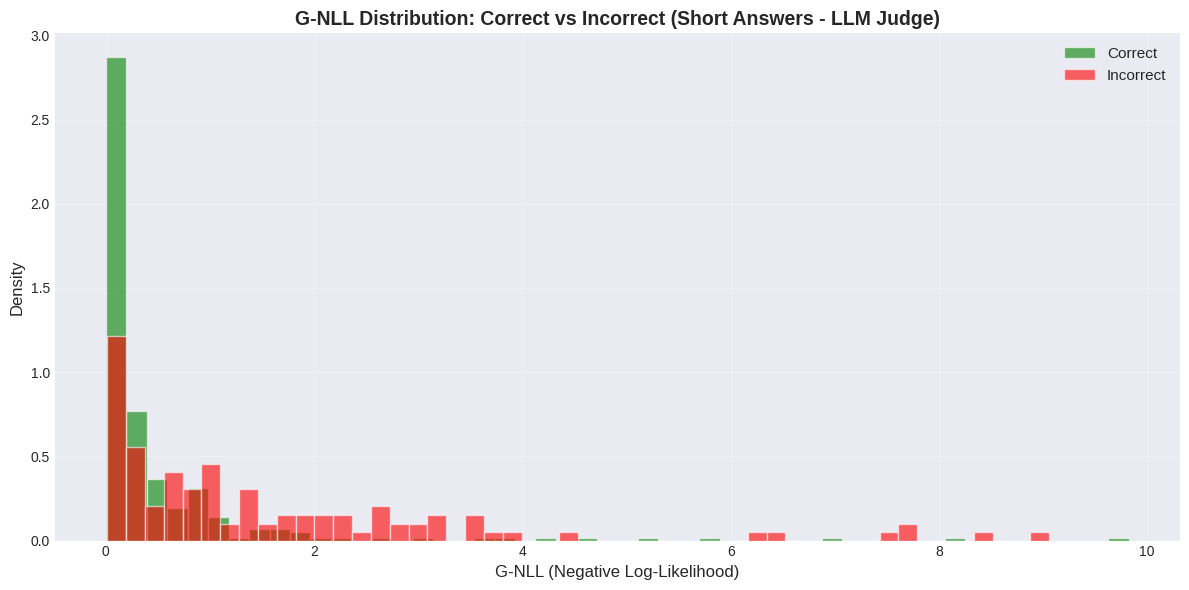


Statistics (Short Answers - LLM Judge):
  Correct answers - Mean G-NLL: 0.5064, Std: 1.1137
  Incorrect answers - Mean G-NLL: 1.6013, Std: 1.9157


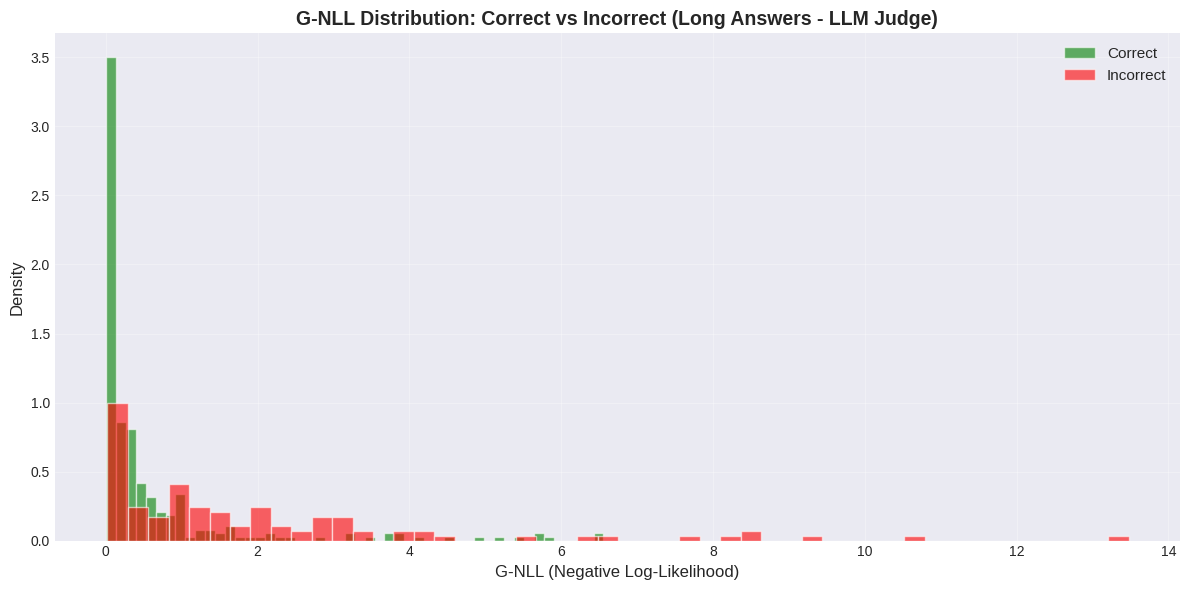


Statistics (Long Answers - LLM Judge):
  Correct answers - Mean G-NLL: 0.6095, Std: 1.1448
  Incorrect answers - Mean G-NLL: 1.9728, Std: 2.4602


In [7]:
def plot_gnll_distribution(details, title_suffix=""):
    """Plot G-NLL distribution for correct vs incorrect answers."""
    if not details:
        print("No details data available")
        return
    
    gnll = np.array(details['gnll_uncertainties'])
    y_true = np.array(details['y_true'])
    
    correct_nll = gnll[y_true == 1]
    incorrect_nll = gnll[y_true == 0]
    
    plt.figure(figsize=(12, 6))
    plt.hist(correct_nll, bins=50, alpha=0.6, label='Correct', color='green', density=True)
    plt.hist(incorrect_nll, bins=50, alpha=0.6, label='Incorrect', color='red', density=True)
    plt.xlabel('G-NLL (Negative Log-Likelihood)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'G-NLL Distribution: Correct vs Incorrect{title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics{title_suffix}:")
    print(f"  Correct answers - Mean G-NLL: {np.mean(correct_nll):.4f}, Std: {np.std(correct_nll):.4f}")
    print(f"  Incorrect answers - Mean G-NLL: {np.mean(incorrect_nll):.4f}, Std: {np.std(incorrect_nll):.4f}")

# Plot distributions
if short_details_rouge:
    plot_gnll_distribution(short_details_rouge, " (Short Answers - ROUGE)")

if short_details_judge:
    plot_gnll_distribution(short_details_judge, " (Short Answers - LLM Judge)")

if long_details_judge:
    plot_gnll_distribution(long_details_judge, " (Long Answers - LLM Judge)")


### 3. Scatter Plot: G-NLL vs Correctness


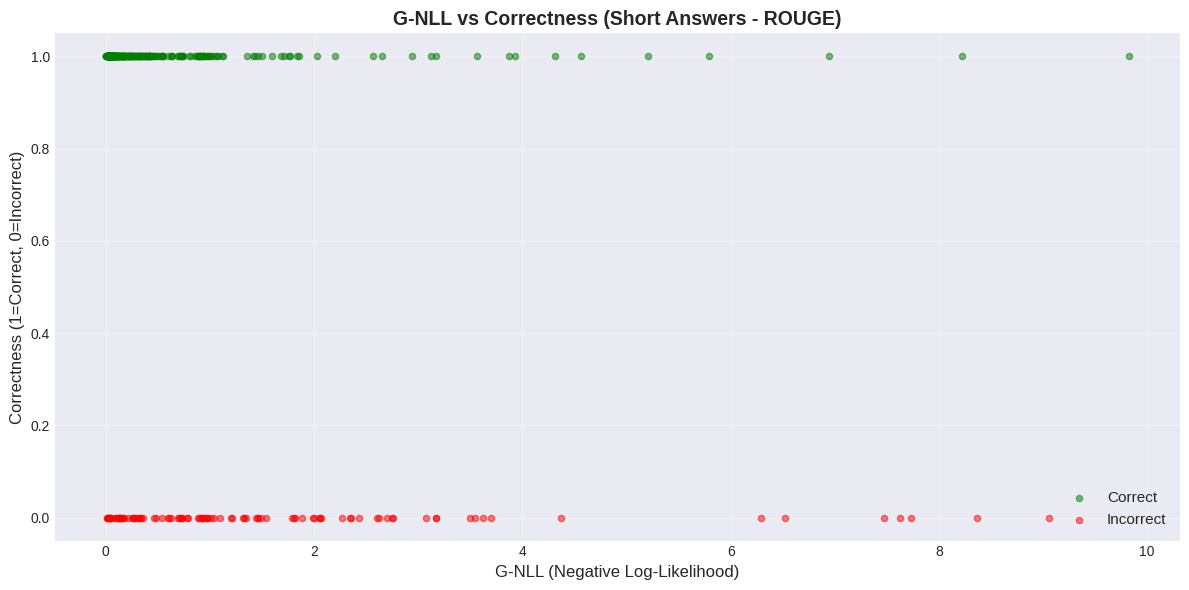

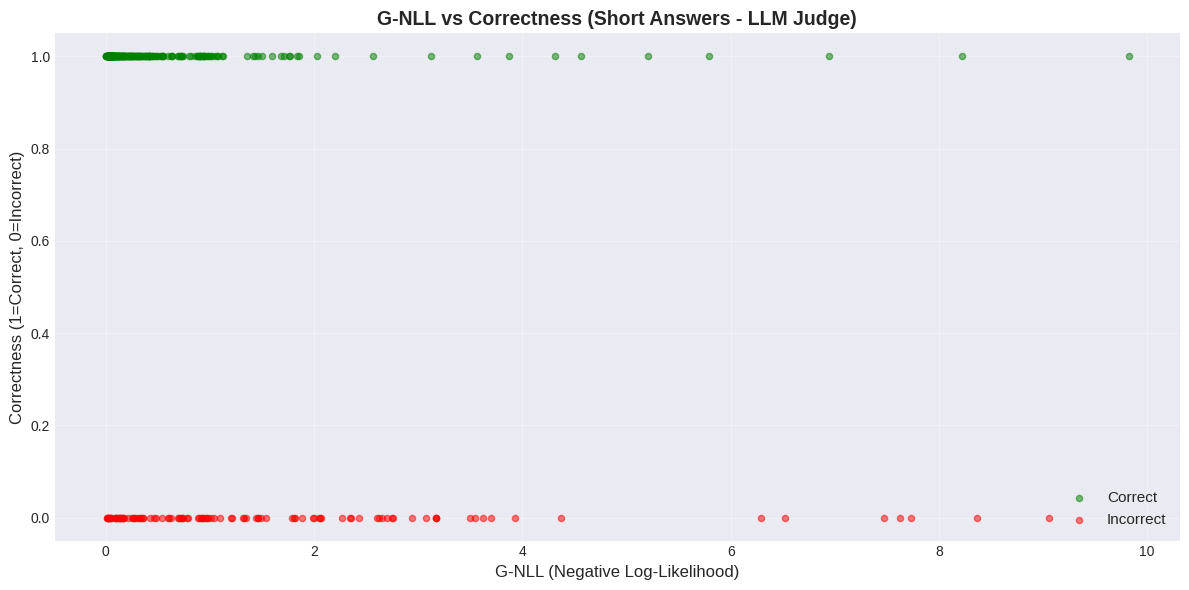

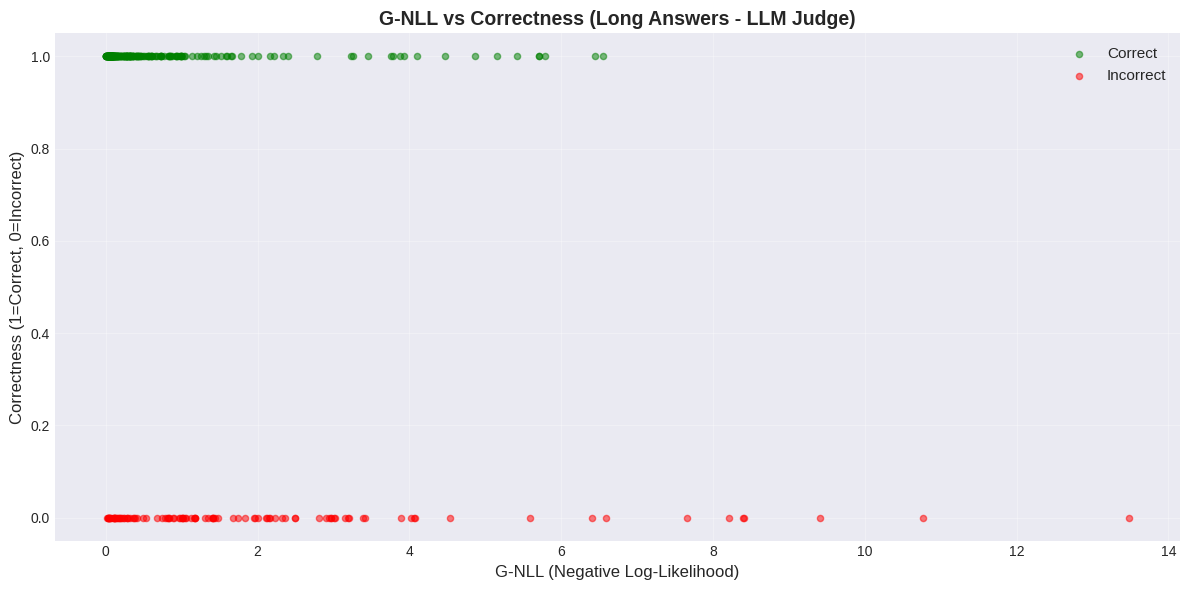

In [8]:
def plot_gnll_vs_correctness(details, title_suffix=""):
    """Plot scatter plot of G-NLL vs correctness."""
    if not details:
        print("No details data available")
        return
    
    gnll = np.array(details['gnll_uncertainties'])
    y_true = np.array(details['y_true'])
    
    plt.figure(figsize=(12, 6))
    plt.scatter(gnll[y_true == 1], y_true[y_true == 1], alpha=0.5, label='Correct', color='green', s=20)
    plt.scatter(gnll[y_true == 0], y_true[y_true == 0], alpha=0.5, label='Incorrect', color='red', s=20)
    plt.xlabel('G-NLL (Negative Log-Likelihood)', fontsize=12)
    plt.ylabel('Correctness (1=Correct, 0=Incorrect)', fontsize=12)
    plt.title(f'G-NLL vs Correctness{title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot scatter plots
if short_details_rouge:
    plot_gnll_vs_correctness(short_details_rouge, " (Short Answers - ROUGE)")

if short_details_judge:
    plot_gnll_vs_correctness(short_details_judge, " (Short Answers - LLM Judge)")

if long_details_judge:
    plot_gnll_vs_correctness(long_details_judge, " (Long Answers - LLM Judge)")


### 4. ROUGE Scores Analysis (Short Answers Only)


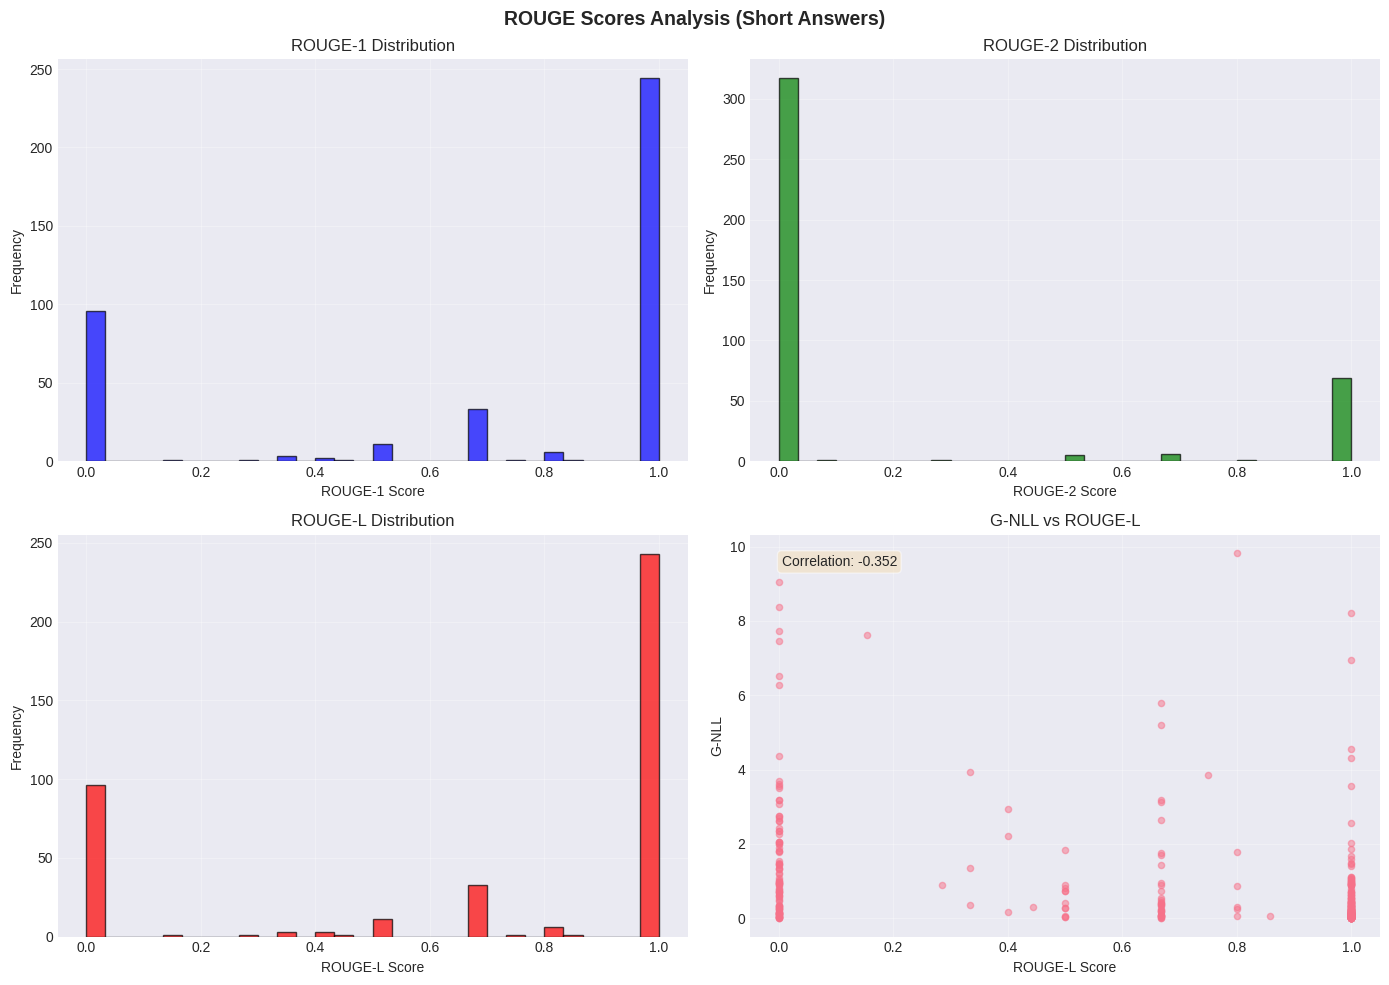


ROUGE Statistics (Short Answers):
  ROUGE-1 - Mean: 0.7015, Std: 0.4204
  ROUGE-2 - Mean: 0.1917, Std: 0.3839
  ROUGE-L - Mean: 0.7000, Std: 0.4204
  G-NLL vs ROUGE-L Correlation: -0.3515


In [9]:
def plot_rouge_scores(details, title_suffix=""):
    """Plot ROUGE score distributions and correlations with G-NLL."""
    if not details or not details['rouge_scores']:
        print("No ROUGE scores available")
        return
    
    rouge_scores = details['rouge_scores']
    gnll = np.array(details['gnll_uncertainties'])
    
    rouge1 = [r['rouge1'] for r in rouge_scores if r]
    rouge2 = [r['rouge2'] for r in rouge_scores if r]
    rougeL = [r['rougeL'] for r in rouge_scores if r]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ROUGE score distributions
    axes[0, 0].hist(rouge1, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_xlabel('ROUGE-1 Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('ROUGE-1 Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].hist(rouge2, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_xlabel('ROUGE-2 Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('ROUGE-2 Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].hist(rougeL, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].set_xlabel('ROUGE-L Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('ROUGE-L Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # G-NLL vs ROUGE-L scatter
    axes[1, 1].scatter(rougeL, gnll[:len(rougeL)], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('ROUGE-L Score')
    axes[1, 1].set_ylabel('G-NLL')
    axes[1, 1].set_title('G-NLL vs ROUGE-L')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Calculate correlation
    if len(rougeL) > 0:
        correlation = np.corrcoef(rougeL, gnll[:len(rougeL)])[0, 1]
        axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[1, 1].transAxes, 
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'ROUGE Scores Analysis{title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nROUGE Statistics{title_suffix}:")
    print(f"  ROUGE-1 - Mean: {np.mean(rouge1):.4f}, Std: {np.std(rouge1):.4f}")
    print(f"  ROUGE-2 - Mean: {np.mean(rouge2):.4f}, Std: {np.std(rouge2):.4f}")
    print(f"  ROUGE-L - Mean: {np.mean(rougeL):.4f}, Std: {np.std(rougeL):.4f}")
    if len(rougeL) > 0:
        print(f"  G-NLL vs ROUGE-L Correlation: {correlation:.4f}")

if short_details_rouge:
    plot_rouge_scores(short_details_rouge, " (Short Answers)")


### 5. LLM Judge Accuracy Analysis


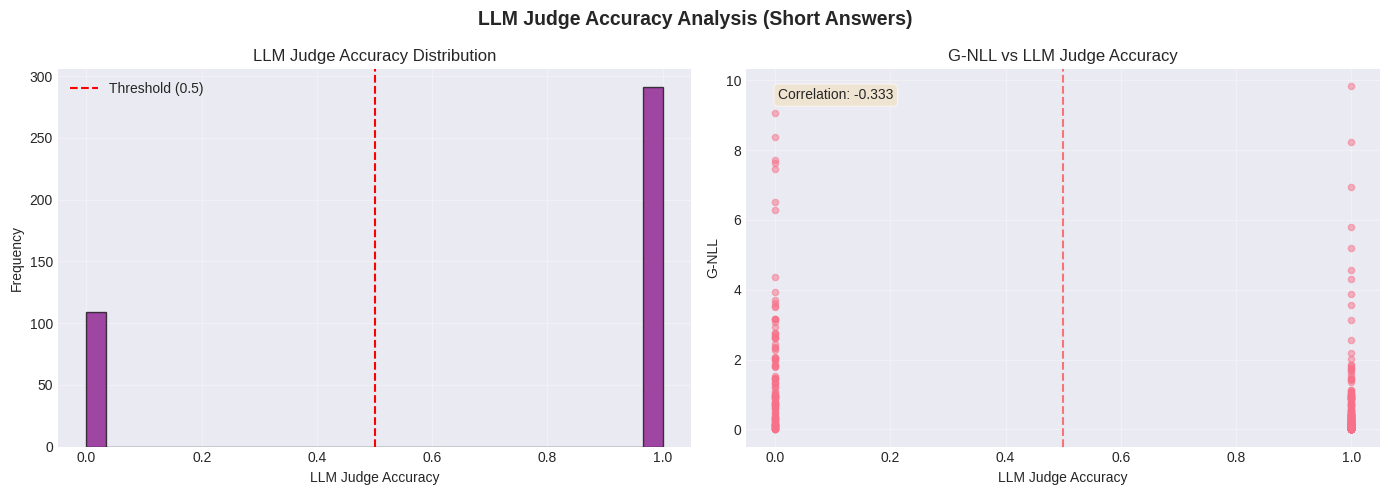


LLM Judge Statistics (Short Answers):
  Mean Accuracy: 0.7275, Std: 0.4452
  Min Accuracy: 0.0000, Max: 1.0000
  G-NLL vs Judge Accuracy Correlation: -0.3332


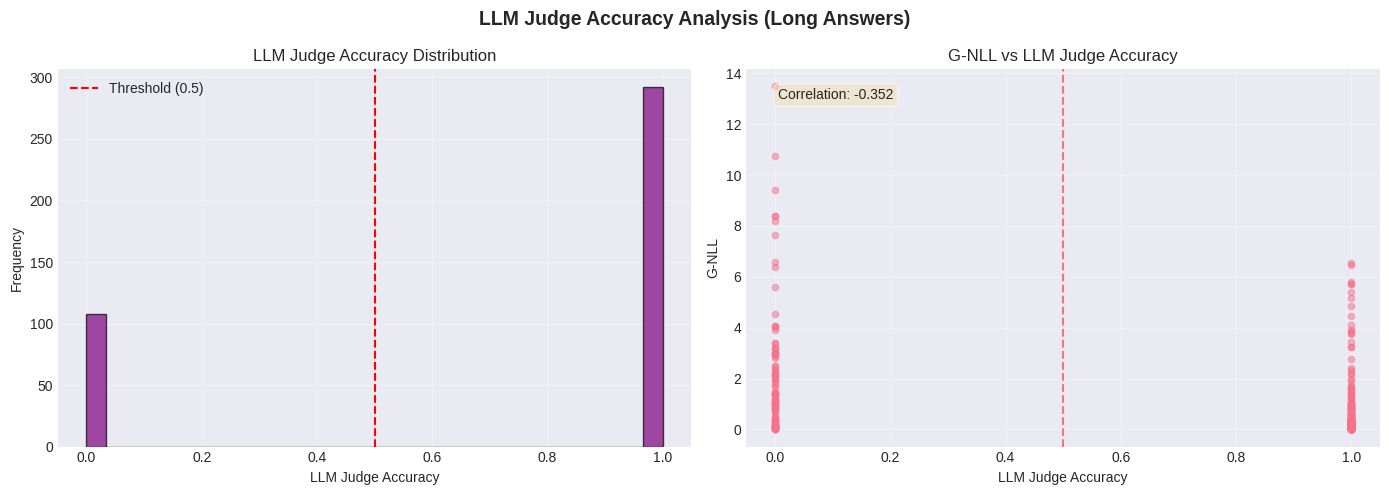


LLM Judge Statistics (Long Answers):
  Mean Accuracy: 0.7300, Std: 0.4440
  Min Accuracy: 0.0000, Max: 1.0000
  G-NLL vs Judge Accuracy Correlation: -0.3519


In [10]:
def plot_judge_accuracy(details, title_suffix=""):
    """Plot LLM judge accuracy distributions and correlations with G-NLL."""
    if not details or details['judge_accuracies'] is None:
        print("No LLM judge accuracy data available")
        return
    
    judge_acc = np.array(details['judge_accuracies'])
    gnll = np.array(details['gnll_uncertainties'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Judge accuracy distribution
    axes[0].hist(judge_acc, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0].set_xlabel('LLM Judge Accuracy')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('LLM Judge Accuracy Distribution')
    axes[0].axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # G-NLL vs Judge Accuracy scatter
    axes[1].scatter(judge_acc, gnll, alpha=0.5, s=20)
    axes[1].set_xlabel('LLM Judge Accuracy')
    axes[1].set_ylabel('G-NLL')
    axes[1].set_title('G-NLL vs LLM Judge Accuracy')
    axes[1].axvline(0.5, color='red', linestyle='--', alpha=0.5)
    axes[1].grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = np.corrcoef(judge_acc, gnll)[0, 1]
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'LLM Judge Accuracy Analysis{title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nLLM Judge Statistics{title_suffix}:")
    print(f"  Mean Accuracy: {np.mean(judge_acc):.4f}, Std: {np.std(judge_acc):.4f}")
    print(f"  Min Accuracy: {np.min(judge_acc):.4f}, Max: {np.max(judge_acc):.4f}")
    print(f"  G-NLL vs Judge Accuracy Correlation: {correlation:.4f}")

if short_details_judge:
    plot_judge_accuracy(short_details_judge, " (Short Answers)")

if long_details_judge:
    plot_judge_accuracy(long_details_judge, " (Long Answers)")


## Sample Answers Display

Display sample questions, answers, and metrics.


In [11]:
def display_sample_answers(details, results, num_samples=10, use_rouge=False, title_suffix="", 
                          show_extremes=False):
    """Display sample questions, answers, and metrics."""
    if not details:
        print("No details data available")
        return
    
    gnll = np.array(details['gnll_uncertainties'])
    
    # If show_extremes, show highest and lowest G-NLL examples
    if show_extremes and len(gnll) > 0:
        indices = []
        # Highest G-NLL (most uncertain)
        highest_indices = np.argsort(gnll)[-num_samples//2:][::-1]
        # Lowest G-NLL (most confident)
        lowest_indices = np.argsort(gnll)[:num_samples//2]
        indices = list(lowest_indices) + list(highest_indices)
    else:
        indices = list(range(min(num_samples, len(details['questions']))))
    
    print(f"\n{'='*80}")
    print(f"Sample Answers{title_suffix}")
    if show_extremes:
        print("(Showing examples with lowest and highest G-NLL)")
    print(f"{'='*80}")
    print(f"Showing {len(indices)} examples (out of {len(details['questions'])})")
    print(f"Overall AUROC: {results['G-NLL_AUROC']:.4f}, Accuracy: {results['Accuracy']:.4f}")
    print(f"{'='*80}\n")
    
    # Display in a more readable format
    for i, idx in enumerate(indices):
        label = "Lowest G-NLL" if i < len(indices)//2 else "Highest G-NLL"
        print(f"\n--- Example {i + 1} ({label}) ---")
        print(f"Question: {details['questions'][idx][:200]}...")
        print(f"Response: {details['responses'][idx][:200]}...")
        print(f"G-NLL: {gnll[idx]:.4f}")
        print(f"Correct: {'✓' if details['y_true'][idx] == 1 else '✗'}")
        
        if use_rouge and details['rouge_scores'] and details['rouge_scores'][idx]:
            r = details['rouge_scores'][idx]
            print(f"ROUGE-1: {r['rouge1']:.3f}, ROUGE-2: {r['rouge2']:.3f}, ROUGE-L: {r['rougeL']:.3f}")
            if details['references'] and details['references'][idx]:
                ref = details['references'][idx][0]
                print(f"Reference: {ref[:150]}..." if len(ref) > 150 else f"Reference: {ref}")
        elif details['judge_accuracies'] and details['judge_accuracies'][idx] is not None:
            print(f"Judge Accuracy: {details['judge_accuracies'][idx]:.3f}")
        print()

# Display samples
if short_details_rouge and short_results_rouge:
    display_sample_answers(short_details_rouge, short_results_rouge, num_samples=5, 
                          use_rouge=True, title_suffix=" (Short Answers - ROUGE)")

if short_details_judge and short_results_judge:
    display_sample_answers(short_details_judge, short_results_judge, num_samples=5, 
                          use_rouge=False, title_suffix=" (Short Answers - LLM Judge)")

if long_details_judge and long_results_judge:
    display_sample_answers(long_details_judge, long_results_judge, num_samples=5, 
                          use_rouge=False, title_suffix=" (Long Answers - LLM Judge)")



Sample Answers (Short Answers - ROUGE)
Showing 5 examples (out of 400)
Overall AUROC: 0.7579, Accuracy: 0.7550


--- Example 1 (Lowest G-NLL) ---
Question: Which US property tycoon bought Turnberry Golf Course in April?...
Response: donald trump...
G-NLL: 0.0571
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 1.000, ROUGE-L: 1.000
Reference: donald trump


--- Example 2 (Lowest G-NLL) ---
Question: A second referendum is due to be held for which commonwealth to decide whether, among other options, to become the 51st state of the USA?...
Response: puerto rico...
G-NLL: 0.0645
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 1.000, ROUGE-L: 1.000
Reference: puerto rico


--- Example 3 (Highest G-NLL) ---
Question: Of which country was Adrian Nastase Prime Minister from 2000 to 2004?...
Response: romania...
G-NLL: 0.1576
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: romania


--- Example 4 (Highest G-NLL) ---
Question: Which 1st World War battle of 1916 saw 60,000 British casualties on the

### Examples with Extreme G-NLL Values

Show examples with the lowest (most confident) and highest (most uncertain) G-NLL values.


In [12]:
# Display extreme examples
if short_details_rouge and short_results_rouge:
    display_sample_answers(short_details_rouge, short_results_rouge, num_samples=6, 
                          use_rouge=True, title_suffix=" (Short Answers - ROUGE)", 
                          show_extremes=True)

if short_details_judge and short_results_judge:
    display_sample_answers(short_details_judge, short_results_judge, num_samples=6, 
                          use_rouge=False, title_suffix=" (Short Answers - LLM Judge)",
                          show_extremes=True)

if long_details_judge and long_results_judge:
    display_sample_answers(long_details_judge, long_results_judge, num_samples=6, 
                          use_rouge=False, title_suffix=" (Long Answers - LLM Judge)",
                          show_extremes=True)



Sample Answers (Short Answers - ROUGE)
(Showing examples with lowest and highest G-NLL)
Showing 6 examples (out of 400)
Overall AUROC: 0.7579, Accuracy: 0.7550


--- Example 1 (Lowest G-NLL) ---
Question: Which band was founded by Chris Difford and Glenn Tilbrook in 1974?...
Response: squeeze...
G-NLL: 0.0001
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: squeeze


--- Example 2 (Lowest G-NLL) ---
Question: rtve is the state broadcaster in which country?...
Response: spain...
G-NLL: 0.0002
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: spain


--- Example 3 (Lowest G-NLL) ---
Question: The character Sally Bowles appears in which film?...
Response: cabaret...
G-NLL: 0.0015
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: cabaret


--- Example 4 (Highest G-NLL) ---
Question: Which sporting trophy is made of melted silver rupees?...
Response: the Calcutta cup...
G-NLL: 9.8240
Correct: ✓
ROUGE-1: 0.800, ROUGE-2: 0.667, ROUGE-

## Summary Statistics

Create a comprehensive summary table of all results.


In [13]:
# Create summary table
summary_data = []

if short_results_rouge:
    summary_data.append({
        'Type': 'Short Answers',
        'Metric': 'ROUGE-L',
        'AUROC': f"{short_results_rouge['G-NLL_AUROC']:.4f}",
        'Accuracy': f"{short_results_rouge['Accuracy']:.4f}",
        'Num Examples': short_results_rouge['Num_examples'],
        'Mean G-NLL': f"{short_results_rouge['Mean_G-NLL']:.4f}",
        'Std G-NLL': f"{short_results_rouge['Std_G-NLL']:.4f}"
    })

if short_results_judge:
    summary_data.append({
        'Type': 'Short Answers',
        'Metric': 'LLM Judge',
        'AUROC': f"{short_results_judge['G-NLL_AUROC']:.4f}",
        'Accuracy': f"{short_results_judge['Accuracy']:.4f}",
        'Num Examples': short_results_judge['Num_examples'],
        'Mean G-NLL': f"{short_results_judge['Mean_G-NLL']:.4f}",
        'Std G-NLL': f"{short_results_judge['Std_G-NLL']:.4f}"
    })

if long_results_judge:
    summary_data.append({
        'Type': 'Long Answers',
        'Metric': 'LLM Judge',
        'AUROC': f"{long_results_judge['G-NLL_AUROC']:.4f}",
        'Accuracy': f"{long_results_judge['Accuracy']:.4f}",
        'Num Examples': long_results_judge['Num_examples'],
        'Mean G-NLL': f"{long_results_judge['Mean_G-NLL']:.4f}",
        'Std G-NLL': f"{long_results_judge['Std_G-NLL']:.4f}"
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)
else:
    print("No results available to summarize.")



SUMMARY STATISTICS
         Type    Metric  AUROC Accuracy  Num Examples Mean G-NLL Std G-NLL
Short Answers   ROUGE-L 0.7579   0.7550           400     0.8047    1.4629
Short Answers LLM Judge 0.7575   0.7275           400     0.8047    1.4629
 Long Answers LLM Judge 0.7516   0.7300           400     0.9776    1.7197


## Export Results

Save results to JSON file for later use.


In [14]:
# Export results to JSON
results_export = {}

if short_results_rouge:
    results_export['short_rouge'] = {
        'G-NLL_AUROC': float(short_results_rouge['G-NLL_AUROC']),
        'Accuracy': float(short_results_rouge['Accuracy']),
        'Num_examples': int(short_results_rouge['Num_examples']),
        'Mean_G-NLL': float(short_results_rouge['Mean_G-NLL']),
        'Std_G-NLL': float(short_results_rouge['Std_G-NLL']),
        'Min_G-NLL': float(short_results_rouge['Min_G-NLL']),
        'Max_G-NLL': float(short_results_rouge['Max_G-NLL'])
    }

if short_results_judge:
    results_export['short_judge'] = {
        'G-NLL_AUROC': float(short_results_judge['G-NLL_AUROC']),
        'Accuracy': float(short_results_judge['Accuracy']),
        'Num_examples': int(short_results_judge['Num_examples']),
        'Mean_G-NLL': float(short_results_judge['Mean_G-NLL']),
        'Std_G-NLL': float(short_results_judge['Std_G-NLL']),
        'Min_G-NLL': float(short_results_judge['Min_G-NLL']),
        'Max_G-NLL': float(short_results_judge['Max_G-NLL'])
    }

if long_results_judge:
    results_export['long_judge'] = {
        'G-NLL_AUROC': float(long_results_judge['G-NLL_AUROC']),
        'Accuracy': float(long_results_judge['Accuracy']),
        'Num_examples': int(long_results_judge['Num_examples']),
        'Mean_G-NLL': float(long_results_judge['Mean_G-NLL']),
        'Std_G-NLL': float(long_results_judge['Std_G-NLL']),
        'Min_G-NLL': float(long_results_judge['Min_G-NLL']),
        'Max_G-NLL': float(long_results_judge['Max_G-NLL'])
    }

if results_export:
    output_file = 'gnll_baseline_analysis_results.json'
    with open(output_file, 'w') as f:
        json.dump(results_export, f, indent=2)
    print(f"\n✅ Results exported to {output_file}")
else:
    print("No results to export.")



✅ Results exported to gnll_baseline_analysis_results.json
